In [ ]:
## Import Libraries
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import os

from keras.layers import Dense, Flatten
from keras.models import Model
import keras

In [ ]:
## Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Data paths
train_dir = '/content/drive/MyDrive/OTB/Data/train'
val_dir = '/content/drive/MyDrive/OTB/Data/test'

In [ ]:
## Sample image path
sample_image_path = '/content/drive/MyDrive/OTB/Data/train/Bus/100.jpeg'

In [ ]:
## Sample image shape
imread(sample_image_path).shape

(259, 194, 3)

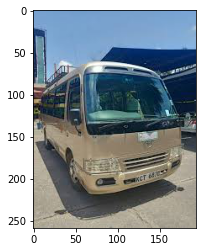

In [ ]:
## View sample image
plt.imshow(imread(sample_image_path))

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
## Create data generator
datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)

In [ ]:
## Train data
train_generator = datagen.flow_from_directory(
    train_dir, 
    target_size = (img_width,img_height),
    batch_size= batch_size
)


Found 748 images belonging to 4 classes.


In [ ]:
## Validation data
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size = (img_width,img_height),
    batch_size= batch_size
)

Found 120 images belonging to 4 classes.


In [ ]:
## Check class indices
train_generator.class_indices

{'Bus': 0, 'Nissan': 1, 'Saloon': 2, 'Truck': 3}

In [ ]:
## Class length
classes = len(train_generator.class_indices)
classes

4

In [ ]:
## Download base model
base_model = VGG19(input_shape=(img_width,img_height,3),include_top=False)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
## Do not retrain whole model
for layer in base_model.layers:
  layer.trainable = False


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
## Customize output layer
X = Flatten()(base_model.output)

X = Dense(units=classes,activation='softmax')(X)

## creating model

model = Model(base_model.input,X)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
## Compile
model.compile(optimizer='adam',loss= keras.losses.categorical_crossentropy,metrics='accuracy')

In [ ]:
## Early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=5,verbose=1)

mc = ModelCheckpoint(filepath='best_model.h5',monitor='val_accuracy',min_delta=0.01,patience=5,verbose=1,save_best_only=True)

cb = [es,mc]

In [ ]:
%%time
#his = model.fit(train_ds,steps_per_epoch=16,epochs=50,verbose=1,callbacks=cb,validation_data=val_ds,validation_steps=16)
epochs = 10
results = model.fit_generator(train_generator,epochs=10,verbose=1,validation_data=val_generator,callbacks=cb)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 9.1044 - accuracy: 0.6417
Epoch 00001: val_accuracy improved from -inf to 0.74167, saving model to best_model.h5
24/24 [==============================] - 311s 12s/step - loss: 9.1044 - accuracy: 0.6417 - val_loss: 9.3540 - val_accuracy: 0.7417
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 5.2534 - accuracy: 0.8396
Epoch 00002: val_accuracy improved from 0.74167 to 0.82500, saving model to best_model.h5
24/24 [==============================] - 15s 614ms/step - loss: 5.2534 - accuracy: 0.8396 - val_loss: 5.8186 - val_accuracy: 0.8250
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 3.2136 - accuracy: 0.8877
Epoch 00003: val_accuracy improved from 0.82500 to 0.89167, saving model to best_model.h5
24/24 [==============================] - 15s 608ms/step - loss: 3.2136 - accuracy: 0.8877 - val_loss: 4.0275 - val_accuracy: 0.8917
Epoch 4/10
24/24 [==============================] - ETA:

In [ ]:
h = results.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

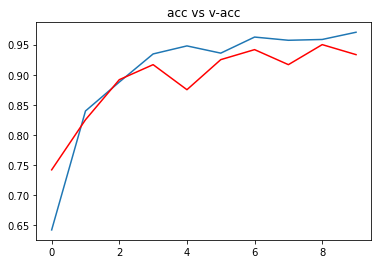

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title('acc vs v-acc')
plt.show()

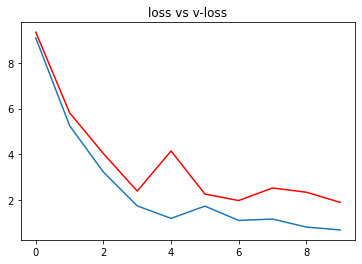

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c='red')
plt.title('loss vs v-loss')
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/best_model.h5')

In [ ]:
prediction_image_path = '/content/drive/MyDrive/OTB/Data/train/Truck/102.jpeg'

In [ ]:
class_names_dict = train_generator.class_indices
class_names_list = list(class_names_dict.keys())
class_names_list

['Bus', 'Nissan', 'Saloon', 'Truck']

In [ ]:
def prediction(path):

  img = load_img(prediction_image_path,target_size=(256,256))

  i = img_to_array(img)

  im = preprocess_input(i)

  img = np.expand_dims(im,axis=0)

  predictions = model.predict(img)

  print(predictions)

  highest_prob = np.max(predictions)

  predicted_class = class_names_list[np.argmax(predictions)]

 

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_class, 100 * highest_prob)
    )

  ## Plot image

  plt.imshow(imread(prediction_image_path))

[[0. 0. 0. 1.]]
This image most likely belongs to Truck with a 100.00 percent confidence.


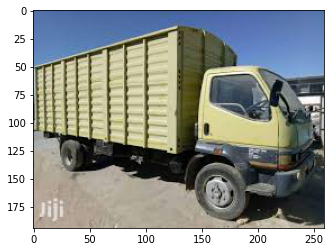

In [ ]:
prediction(prediction_image_path)

In [ ]:
ref = dict(zip(list(train_generator.class_indices.values()),list(train_generator.class_indices.keys())))
ref

{0: 'Bus', 1: 'Nissan', 2: 'Saloon', 3: 'Truck'}

In [ ]:
import pickle

In [ ]:
vehicle_names = open("vehicle_dict.pkl", "wb")
pickle.dump(ref, vehicle_names)
vehicle_names.close()

In [ ]:
os.getcwd()

'/content'

In [ ]:
vehicles_names = open("vehicle_dict.pkl", "rb")
output = pickle.load(vehicles_names)
print(output)

{0: 'Bus', 1: 'Nissan', 2: 'Saloon', 3: 'Truck'}
